In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [2]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [3]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [4]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [5]:
output_dist = start_SOGA(cfg, params_dict)

In [6]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]])]>

In [7]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1450.6539306640625
mean: 7.360479831695557 loss: 534.9014282226562
mean: 8.92947006225586 loss: 218.827392578125
mean: 9.72329330444336 loss: 154.52198791503906
mean: 10.01565170288086 loss: 147.2344512939453
mean: 10.091751098632812 loss: 146.80545043945312
mean: 10.105135917663574 loss: 146.79364013671875
mean: 10.10654067993164 loss: 146.79351806640625
mean: 10.106590270996094 loss: 146.7935333251953
mean: 10.106590270996094 loss: 146.7935333251953


In [9]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(147.3615)
Likelihood in the optimized distribution:  tensor(146.7935, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [10]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [11]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [12]:
output_dist = start_SOGA(cfg, params_dict)

In [13]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([10.])] sigma: [tensor([[4.]], grad_fn=<CopySlices>)]>

In [14]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0198)


In [15]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1741.964599609375
std: 1.4899107217788696 loss: 1555.215087890625
std: 1.0774412155151367 loss: 1441.5721435546875
std: 1.015802264213562 loss: 1438.097900390625
std: 1.0193947553634644 loss: 1438.0828857421875
std: 1.0193475484848022 loss: 1438.0828857421875
std: 1.0193272829055786 loss: 1438.082763671875
std: 1.0193291902542114 loss: 1438.082763671875
std: 1.0193290710449219 loss: 1438.082763671875
std: 1.0193290710449219 loss: 1438.082763671875


In [16]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1438.4540)
Likelihood in the optimized distribution:  tensor(1438.0828, grad_fn=<NegBackward0>)


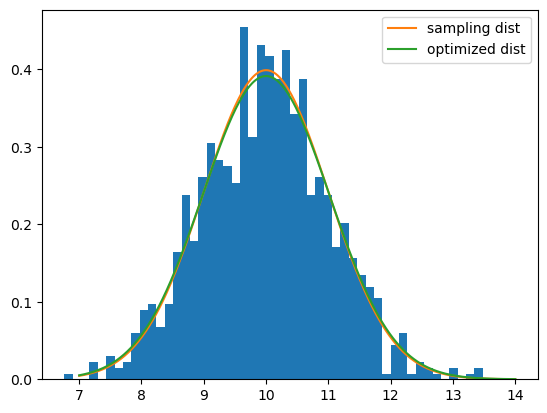

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [18]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [19]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [20]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [21]:
output_dist = start_SOGA(cfg, params_dict)

In [22]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([1.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>)]>

In [23]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [24]:
torch.var(samples)

tensor(4.1771)

In [25]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3503.507568359375
par1: 1.408010482788086 loss: 2408.1787109375
par1: 1.6148241758346558 loss: 2228.218505859375
par1: 1.7429603338241577 loss: 2172.699462890625
par1: 1.8304740190505981 loss: 2150.6884765625
par1: 1.8920314311981201 loss: 2141.129150390625
par1: 1.9356215000152588 loss: 2136.83251953125
par1: 1.9663320779800415 loss: 2134.893310546875
par1: 1.9876949787139893 loss: 2134.031005859375
par1: 2.002286911010742 loss: 2133.658447265625


In [26]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2133.7000)
Likelihood in the optimized distribution:  tensor(2133.5037, grad_fn=<NegBackward0>)


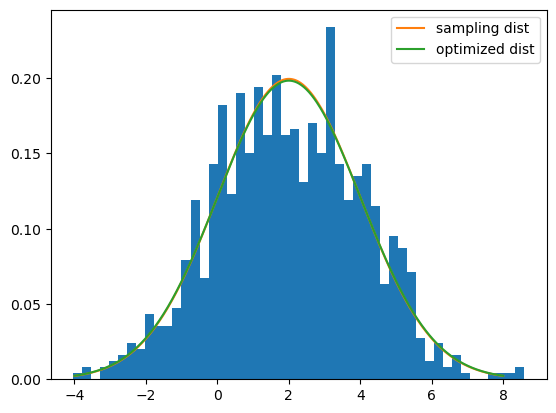

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [28]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [29]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [30]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [31]:
output_dist = start_SOGA(cfg, params_dict)

In [32]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([4.], grad_fn=<CopySlices>)] sigma: [tensor([[4.]])]>

In [33]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [34]:
torch.var(samples)

tensor(3.9925)

In [35]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2246.871826171875
par2: 1.9493082761764526 loss: 2234.2080078125
par2: 1.9007078409194946 loss: 2222.417724609375
par2: 1.8533333539962769 loss: 2211.493896484375
par2: 1.8071974515914917 loss: 2201.395263671875
par2: 1.7623103857040405 loss: 2192.0810546875
par2: 1.718683123588562 loss: 2183.51123046875
par2: 1.6763266324996948 loss: 2175.646240234375
par2: 1.6352512836456299 loss: 2168.448486328125
par2: 1.595467448234558 loss: 2161.879150390625


In [36]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2110.8948)
Likelihood in the optimized distribution:  tensor(2155.9014, grad_fn=<NegBackward0>)


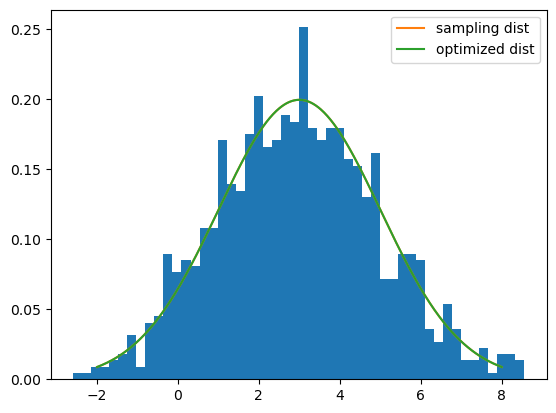

In [37]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [38]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [39]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [40]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [41]:
output_dist = start_SOGA(cfg, params_dict)

In [42]:
output_dist

Dist<['a'],pi: [tensor(0.3085, grad_fn=<UnbindBackward0>), tensor(0.6915, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

In [43]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

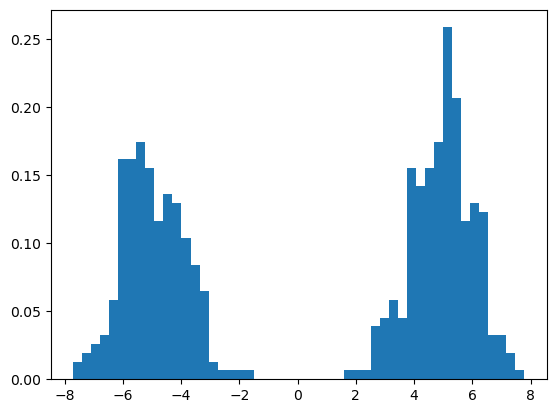

In [44]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [45]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [46]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1110.12255859375
mean: 0.2212824523448944 loss: 1088.490478515625
mean: 0.10541582852602005 loss: 1086.298828125
mean: 0.10611866414546967 loss: 1086.300048828125
mean: 0.11146888136863708 loss: 1086.2965087890625
mean: 0.11045098304748535 loss: 1086.29638671875
mean: 0.11050094664096832 loss: 1086.29638671875
mean: 0.1105232685804367 loss: 1086.29638671875
mean: 0.1105143204331398 loss: 1086.29638671875
mean: 0.11051662266254425 loss: 1086.29638671875


In [47]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(0.5), torch.tensor(0.5)], [torch.tensor([-5.]), torch.tensor([5.])], [torch.tensor([[1.]]), torch.tensor([[1.]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1088.2349)
Likelihood in the optimized distribution:  tensor(1086.2964, grad_fn=<NegBackward0>)


In [48]:
output_dist

Dist<['a'],pi: [tensor(0.4560, grad_fn=<UnbindBackward0>), tensor(0.5440, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

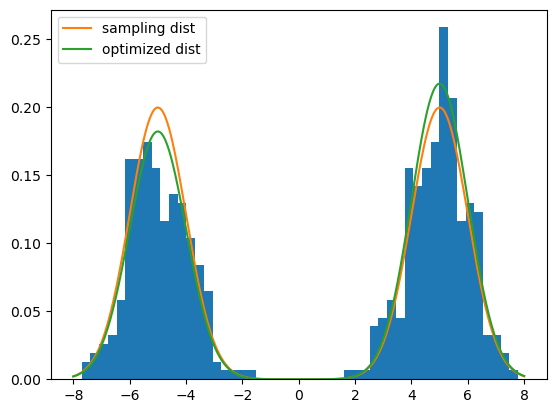

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [50]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [51]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [52]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [53]:
output_dist = start_SOGA(cfg, params_dict)

In [54]:
output_dist

Dist<['a'],pi: [tensor(0.6915, grad_fn=<UnbindBackward0>), tensor(0.3085, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

In [55]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

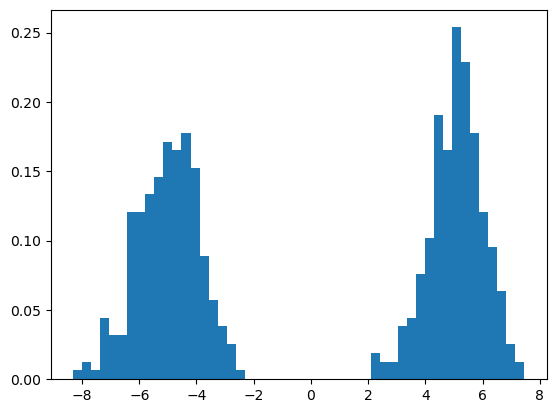

In [56]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [57]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1112.5360107421875
coeff: 0.2101358324289322 loss: 1076.8084716796875
coeff: 0.02956557460129261 loss: 1067.0458984375
coeff: -0.03507285565137863 loss: 1066.18896484375
coeff: -0.0425918884575367 loss: 1066.184326171875
coeff: -0.04045708477497101 loss: 1066.183349609375
coeff: -0.04000416398048401 loss: 1066.183349609375
coeff: -0.04011157527565956 loss: 1066.183349609375
coeff: -0.040122147649526596 loss: 1066.183349609375
coeff: -0.04011610895395279 loss: 1066.183349609375


In [58]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(0.5), torch.tensor(0.5)], [torch.tensor([-5.]), torch.tensor([5.])], [torch.tensor([[1.]]), torch.tensor([[1.]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1066.4393)
Likelihood in the optimized distribution:  tensor(1066.1833, grad_fn=<NegBackward0>)


In [59]:
output_dist

Dist<['a'],pi: [tensor(0.4840, grad_fn=<UnbindBackward0>), tensor(0.5160, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

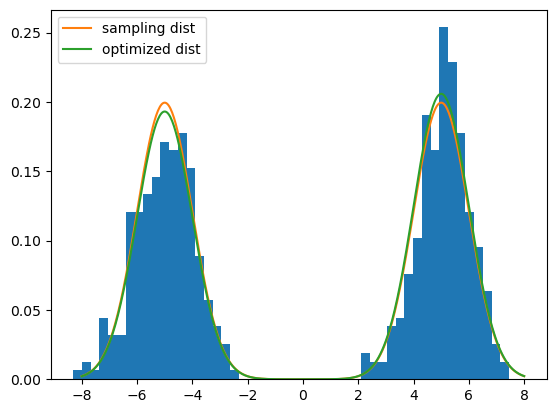

In [60]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [61]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [62]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)

In [63]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [64]:
output_dist = start_SOGA(cfg, params_dict)

In [65]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[6.2500]], grad_fn=<CopySlices>)]>

In [66]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0047)


In [67]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3908.356689453125
mean: 5.880666732788086std: 3.2211966514587402 loss: 2955.1435546875
mean: 6.569733619689941std: 3.4495067596435547 loss: 2693.14697265625
mean: 7.201140880584717std: 3.394254684448242 loss: 2524.09619140625
mean: 7.8263115882873535std: 3.1026551723480225 loss: 2348.823974609375
mean: 8.485867500305176std: 2.56490421295166 loss: 2112.478515625
mean: 9.2305269241333std: 1.7334880828857422 loss: 1737.6776123046875
mean: 9.932119369506836std: 1.0011454820632935 loss: 1425.0272216796875
mean: 9.990850448608398std: 1.004148244857788 loss: 1423.1292724609375
mean: 9.99055290222168std: 1.0041990280151367 loss: 1423.129150390625


In [68]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1423.1913)
Likelihood in the optimized distribution:  tensor(1423.1292, grad_fn=<NegBackward0>)


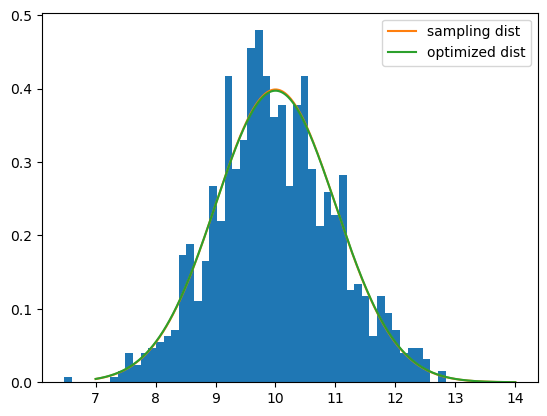

In [69]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()